# Synthetise English text character by character using RNN

In this assignment we train an RNN to synthesize English text character
by character. We train a vanilla RNN with outputs, using the text from the book The Goblet of Fire by J.K. Rowling.
The variation of SGD you will use for the optimization will be AdaGrad.
The final version of the code contains these major components:

- Preparing the data: Read in the training data, determine the number
of unique characters in the text and set up mapping functions - one
mapping each character to a unique index and another mapping each
index to a character.
- Back-propagation: The forward and the backward pass of the backpropagation
algorithm for a vanilla RNN to efficiently compute the
gradients.
- AdaGrad: updating your RNN's parameters
- Synthesizing text from your RNN: Given a learnt set of parameters
for the RNN, a default initial hidden state h0 and an initial input
vector, x0, from which to bootstrap from then you will write a function
to generate a sequence of text.

In [264]:
import numpy as np
import functions
import tensorflow.keras.utils as np_utils
import matplotlib.pyplot as plt
import copy

In [2]:
fname = 'goblet_book.txt'

## Read in the data

Open the text file for training:

In [3]:
with open(fname, 'r') as fid:
    book_data = fid.read()
    
# Extract all the unique characters from the text
book_chars = sorted(set(book_data))
# The dimension of the input/ouput data of the RNN
K = len(book_chars)

Create a dictionnary to convert int to char and char to int:

In [4]:
char_to_ind = {}
ind_to_char = {}
for i, char in enumerate(book_chars):
    char_to_ind[char] = i
    ind_to_char[i] = char

## Set hyper-parameters & initialize the RNN's parameters

Set the hyper parameter:

In [255]:
m = 100 # dimensionality of the hidden layer
eta = 0.1 # learning rate
seq_length = 25 # length of the input sequence
sig = 0.01

Initiliaze the RNN's parameters:

In [256]:
class RNN:
    def __init__(self):
        self.b = np.zeros((m,1))
        self.c = np.zeros((K,1))
        self.U = np.random.randn(m,K)*sig
        self.W = np.random.randn(m,m)*sig
        self.V = np.random.randn(K,m)*sig
        
        self.accum_b = np.zeros_like(self.b)
        self.accum_c = np.zeros_like(self.c)
        self.accum_U = np.zeros_like(self.U)
        self.accum_W = np.zeros_like(self.W)
        self.accum_V = np.zeros_like(self.V)
        
    def update_grad(self, t_grad, eps=1e-14):
        t_grad.clip_gradient()

        self.accum_b += t_grad.b ** 2
        self.b -= (eta / np.sqrt(self.accum_b + eps)) * t_grad.b
        
        self.accum_c += np.square(t_grad.c)
        self.c -= (eta / np.sqrt(self.accum_c + eps)) * t_grad.c
        
        self.accum_U += np.square(t_grad.U)
        self.U -= (eta / np.sqrt(self.accum_U + eps)) * t_grad.U
        
        self.accum_W += np.square(t_grad.W)   
        self.W -= (eta / np.sqrt(self.accum_W + eps)) * t_grad.W
        
        self.accum_V += np.square(t_grad.V)
        self.V -= (eta / np.sqrt(self.accum_V + eps)) * t_grad.V

In [257]:
rnn = RNN()

## Synthesize text from your randomly initialized RNN

Function that will synthesize a sequence of characters using the current parameter values in your RNN:

In [168]:
def synthesize_text(rnn, h_0, x_0, n):
    """
    Attributes:
    
    rnn: parameters of the network
    h0: hidden state at time 0
    x0: first dummy input to RNN (it can be a character like a fullstop)
    n: length of the sequence we want to generate
    ______________________________________________
    Return:
    
    return one hot encoding of the list of characters (d x n)
    
    """
    h = [h_0]
    x = [x_0]
    seq = []
            
    # we genereta the n-1 other characters
    for t in range(1, n+1):
        a_t = rnn.W @ h[t-1] + (rnn.U @ x[t-1]) + rnn.b
        h.append(np.tanh(a_t))
        o_t = rnn.V @ h[t] + rnn.c
        p_t = functions.softmax(o_t)
        
        # add character found to sequence
        seq.append(np.argmax(p_t))
        # randomly select a character based on the output probability scores p 
        x.append(np_utils.to_categorical(((np.where(np.cumsum(p_t) - np.random.rand() > 0)[0])[0]), K)[:,np.newaxis])
        
    return seq

In [169]:
h_0 = np.zeros(m)[:,np.newaxis]
x_0 = '.'

x_0_onthot = np_utils.to_categorical(char_to_ind[x_0], K)[:,np.newaxis]

sentence = [ind_to_char[ind] for ind in synthesize_text(rnn, h_0, x_0_onthot, 200)]
print(''.join(sentence))

Th'yz2XWthThmPPRWYuL3v3yyMtRhSl¼yvdN.eâdX"2qQSLR¢Z¼WMq¢3j!QÃhFâgX;Tâ;;mTLPvT)XhMmoR"¢dvRÃme¢wd(m¼hFeM^¼¢mRWh¼ÃzK¼m?,ew ,CMm;WIi¼vdF¼FzP)gmjzp LQIXyOWdRLW¼X¼Lls3OUM
â-mâZ¼
oIuv"UTRCLFPzDXWw a¢oZYh)¢dÃO


## Implement the forward & backward pass of back-prop

Implement the forward pass for training

In [170]:
def forward_pass(rnn, x, y, h_0):
    """
    Attributes:
    
    rnn: parameters
    x: (K x n), one hot encoded of the input vector
    h_0: (1, m), the first hidden state
    
    """
    data_size = len(x[0])
    h = np.zeros((m, data_size+1))
    h[:,0] = h_0
    p = np.zeros((K, data_size))
    a = np.zeros((m, data_size))

    for t in range(1, data_size+1):
        a[:, t-1] = (rnn.W @ (h[:, t-1][:,np.newaxis]) + rnn.U @ (x[:,t-1][:,np.newaxis]) + rnn.b)[:,0]
        h[:, t] = np.tanh(a[:, t-1])
        o_t = rnn.V @ (h[:, t][:,np.newaxis]) + rnn.c
        p[:, t-1] = functions.softmax(o_t)[:,0]
        
    # compute loss
    loss = 0
    
    # for every data in training data set
    for d in range(0,len(x[0])):
        loss -= y[:,d].T @ np.log(p[:,d])
           
    return a, h, p, loss

In [171]:
h_0 = np.zeros(m)
x = book_data[0:25]
y = book_data[1:26]

# convert char to ind
x = [char_to_ind[char] for char in x]
y = [char_to_ind[char] for char in y]

# convert to one hot encoded
x = np_utils.to_categorical(x, K).T
y = np_utils.to_categorical(y, K).T

a, h, p, loss = forward_pass(rnn, x, y, h_0)

y_predicted_ind = np.argmax(p, axis=0)
y_real_ind = np.argmax(y, axis=0)
print("loss: ", loss)
print("predicted: ", ''.join([ind_to_char[char] for char in y_predicted_ind]))
print("real: ", ''.join([ind_to_char[char] for char in y_real_ind]))

loss:  110.4678595271206
predicted:  yv¼jgLmrtt9jLvhO€ty9LDrO-
real:  ARRY POTTER AND THE GOBLE


Implement the backward pass:

In [189]:
class GRADS:
    def __init__(self):
        self.b = np.zeros((m,1))
        self.c = np.zeros((K,1))
        self.U = np.zeros((m,K))
        self.W = np.zeros((m,m))
        self.V = np.zeros((K,m))
        
    def clip_gradient(self):
        self.b = np.clip(self.b, -5, 5)
        self.c = np.clip(self.c, -5, 5)
        self.U = np.clip(self.U, -5, 5)
        self.W = np.clip(self.W, -5, 5)
        self.V = np.clip(self.V, -5, 5)

In [173]:
def compute_gradient(rnn, y, p, h, a, x):
    """
    Attributes
    
    y: (K x n), one hot encoding of the true label
    p: (K x n), one hot encoding of generated label
    h: (m x n), hidden state
    a: (m x n)
    x: (K x n)
    
    """
    grads = GRADS()
    n = len(y[0])

    # propagate through the loss function
    g = -(y - p) # (K x n)
    for t in range(n):
        grads.V += g[:,t][:,np.newaxis] @ h[:,t+1][:,np.newaxis].T
    grads.c = np.sum(g, axis=1)[:,np.newaxis]
    
    # propagate through the h and a
    da = np.zeros((m,n))
    
    dh_t = g[:,n-1][:,np.newaxis].T @ rnn.V # (1 x m)
    da_t = np.multiply(dh_t, ((1 - np.tanh(a[:,n-1])**2))) # (1 x m)
    da[:,n-1] = da_t
    
    for t in range(n-2, -1, -1):
        dh_t = g[:, t] @ rnn.V + da_t @ rnn.W
        da_t = np.multiply(dh_t, ((1 - np.tanh(a[:,t])**2)))
        da[:,t] = da_t
    
    g = da # (m x n)
    
    for t in range(n):
        grads.W += g[:,t][:,np.newaxis] @ h[:,t][:,np.newaxis].T
    grads.U = g @ x.T
    grads.b = np.sum(g, axis=1)[:,np.newaxis]
    
    return grads

In [174]:
grads = compute_gradient(rnn, y, p, h, a, x)

In [155]:
def ComputeGradsNumSlow(X, Y, h0, W, U, b, V, c, h=1e-4):
    grad_W = np.zeros(W.shape)
    grad_U = np.zeros(U.shape)
    grad_b = np.zeros(b.shape)
    grad_V = np.zeros(V.shape)
    grad_c = np.zeros(c.shape)

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.copy(W)
            W_try[i, j] -= h 
            c1 = ComputeCost(X, Y, h0, W_try, U, b, V, c)

            W_try = np.copy(W)
            W_try[i, j] += h 
            c2 = ComputeCost(X, Y, h0, W_try, U, b, V, c)

            grad_W[i, j] = (c2 - c1) / (2*h)
    
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            U_try = np.copy(U)
            U_try[i, j] -= h 
            c1 = ComputeCost(X, Y, h0, W, U_try, b, V, c)

            U_try = np.copy(U)
            U_try[i, j] += h 
            c2 = ComputeCost(X, Y, h0, W, U_try, b, V, c)

            grad_U[i, j] = (c2 - c1) / (2*h)
    
    for i in range(b.shape[0]):
        b_try = np.copy(b)
        b_try[i, 0] -= h 
        c1 = ComputeCost(X, Y, h0, W, U, b_try, V, c)

        b_try = np.copy(b)
        b_try[i, 0] += h 
        c2 = ComputeCost(X, Y, h0, W, U, b_try, V, c)
        
        grad_b[i, 0] = (c2 - c1) / (2*h)
    
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            V_try = np.copy(V)
            V_try[i, j] -= h 
            c1 = ComputeCost(X, Y, h0, W, U, b, V_try, c)

            V_try = np.copy(V)
            V_try[i, j] += h 
            c2 = ComputeCost(X, Y, h0, W, U, b, V_try, c)

            grad_V[i, j] = (c2 - c1) / (2*h)
    
    for i in range(c.shape[0]):
        c_try = np.copy(c)
        c_try[i, 0] -= h 
        c1 = ComputeCost(X, Y, h0, W, U, b, V, c_try)

        c_try = np.copy(c)
        c_try[i, 0] += h 
        c2 = ComputeCost(X, Y, h0, W, U, b, V, c_try)
        
        grad_c[i, 0] = (c2 - c1) / (2*h)
    
    return grad_W, grad_U, grad_b, grad_V, grad_c

def ComputeCost(x, y, h_0, W, U, b, V, c):
    """
    Attributes:
    
    rnn: parameters
    x: (K x n), one hot encoded of the input vector
    h_0: (1, m), the first hidden state
    
    """
    data_size = len(x[0])
    h = np.zeros((m, data_size+1))
    h[:,0] = h_0
    p = np.zeros((K, data_size))
    a = np.zeros((m, data_size))

    for t in range(1, data_size+1):
        a[:, t-1] = (W @ (h[:, t-1][:,np.newaxis]) + U @ (x[:,t-1][:,np.newaxis]) + b)[:,0]
        h[:, t] = np.tanh(a[:, t-1])
        o_t = V @ (h[:, t][:,np.newaxis]) + c
        p[:, t-1] = functions.softmax(o_t)[:,0]
        
    # compute loss
    loss = 0
    
    # for every data in training data set
    for d in range(0,len(x[0])):
        loss -= y[:,d].T @ np.log(p[:,d])
           
    return loss

In [156]:
grad_W, grad_U, grad_b, grad_V, grad_c = ComputeGradsNumSlow(x, y, h_0, rnn.W, rnn.U, rnn.b, rnn.V, rnn.c)

In [157]:
print("W difference: ", np.min(grad_W - grads.W))
print("U difference: ", np.min(grad_U - grads.U))
print("V difference: ", np.min(grad_V - grads.V))
print("c difference: ", np.min(grad_c - grads.c))
print("b difference: ", np.min(grad_b - grads.b))

W difference:  -4.196708312895897e-10
U difference:  -3.4051592795458774e-10
V difference:  -3.891596823436816e-10
c difference:  1.8859641626178814e-10
b difference:  -8.015867414279398e-10


## Train RNN using AdaGrad

In [268]:
def train_rnn(n_epochs):
    rnn = RNN() 
    h_prev = np.zeros(m)
    smooth_loss = 0

    best_rnn = copy.deepcopy(rnn)
    best_h_prev = h_prev.copy()
    best_loss = 120
    
    loss_array = []

    for epoch in range(n_epochs):
        h_prev = np.zeros(m)

        for e in range(int(len(book_data)/25)):
            
            # construct the x and y
            x = construct_sequence(index=e*seq_length)
            y = construct_sequence(index=e*seq_length+1)

            # forward pass
            a, h, p, loss = forward_pass(rnn, x, y, h_prev)
            
            # set the h_prev
            h_prev = h[:,seq_length]
            
            # compute loss
            if(epoch == 0 and e == 0):
                smooth_loss = loss
            else:
                smooth_loss = 0.999*smooth_loss + loss*0.001

            # update gradient using AdaGrad
            rnn.update_grad(t_grad=compute_gradient(rnn, y, p, h, a, x))
            
            if(smooth_loss < best_loss):
                best_rnn = copy.deepcopy(rnn)
                best_h_prev = h_prev.copy()
                best_loss = smooth_loss
                                                
            if(e % 100 == 0):
                loss_array.append(smooth_loss)
        
            if(e % 10000 == 0):
                print(e, "done from: ", int(len(book_data)/25))
                print("Loss: ", smooth_loss)
                
    print(''.join([ind_to_char[ind] for ind in synthesize_text(best_rnn, best_h_prev[:,np.newaxis], x[:,1][:,np.newaxis], n=1000)]))
    print("Best loss: ", best_loss)
    return loss_array

In [269]:
def construct_sequence(index):
    """
    Returns: one hot label of the char at the index position of the book of length seq_length
    
    """
    x = book_data[index:(index+seq_length)]
    x = [char_to_ind[char] for char in x]
    x = np_utils.to_categorical(x, K).T
    return x  

def plot_loss(lost):
    step_size = 100
    x_axis = [i*step_size for i in range(len(lost))] # get the step size values as the x-axis
    plt.plot(x_axis, lost, label='Loss')
    plt.xlabel('Iter')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [270]:
loss_array = train_rnn(7)

0 done from:  44301
Loss:  110.4717571248234
10000 done from:  44301
Loss:  51.456871762201644
20000 done from:  44301
Loss:  48.721660557959524
30000 done from:  44301
Loss:  47.560913415222885
40000 done from:  44301
Loss:  46.280513785584624
0 done from:  44301
Loss:  45.36974611708533
10000 done from:  44301
Loss:  45.826344550508615
20000 done from:  44301
Loss:  45.1429882565176
30000 done from:  44301
Loss:  45.27848104547684
40000 done from:  44301
Loss:  44.46613710188562
0 done from:  44301
Loss:  43.5191554611222
10000 done from:  44301
Loss:  44.57550351225718
20000 done from:  44301
Loss:  44.128658000979065
30000 done from:  44301
Loss:  44.381263172607795
40000 done from:  44301
Loss:  43.68688595085664
0 done from:  44301
Loss:  42.66398120509616
10000 done from:  44301
Loss:  43.8321810754144
20000 done from:  44301
Loss:  43.34799837565444
30000 done from:  44301
Loss:  43.82887312321486
40000 done from:  44301
Loss:  43.05668863082586
0 done from:  44301
Loss:  42.01

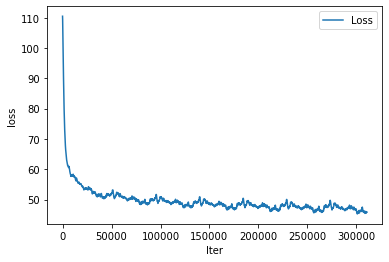

In [236]:
plot_loss(loss_array)